# Analyzing an inspiral-merger-ringdown injection

In this example, we analyze the ringdown of a simulated quasicircular binary-black-hole coalescence, without adding synthetic noise to the data (i.e., a _zero-noise injection_ in LIGO lingo).

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [56]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

## Preamble

In this notebook, we will need some data products produced by the LIGO-Virgo-KAGRA collaborations and the GW community more general:
1. a reference PSDs for computed from LIGO-Virgo data around GW150914 [[LIGO-P1900011](https://dcc.ligo.org/cgi-bin/DocDB/ShowDocument?.submit=Identifier&docid=P1900011&version=)];
2. a data file required by the numerical relativity surrogate waveform `NRSur7dq4` from [Varma et al (2019)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033015) [[doi:10.5281/zenodo.13376190](https://doi.org/10.5281/zenodo.13376190)]

We will use these data products to respectively simulate the instrumental noise and the signal in our data.

_NOTE: if you have a working installation of LALSUITE-EXTRA, you do not need to download the NRSur7dq4 file; simply point `LAL_DATA_PATH` to the corresponding directory below._

In [57]:
!wget -nc https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat
!wget -nc https://zenodo.org/records/13376190/files/NRSur7dq4.h5

/opt/miniconda3/envs/ringdown-jax/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


File ‘GWTC1_GW150914_PSDs.dat’ already there; not retrieving.

File ‘NRSur7dq4.h5’ already there; not retrieving.



The PSD-file we have just downloaded contains three columns of numbers corresponding to frequencies, Hanford (H1) PSD values and Livingston (L1) PSD values. To use this below, we will need to load these data into individual `PowerSpectrum` objects that the _ringdown_ package can recognize.

In [58]:
psds_o1 = np.loadtxt('GWTC1_GW150914_PSDs.dat')

psds_o1 ={
    'H1': rd.PowerSpectrum(psds_o1[:,1], index=psds_o1[:,0], ifo='H1').complete_low_frequencies(),
    'L1': rd.PowerSpectrum(psds_o1[:,2], index=psds_o1[:,0], ifo='L1').complete_low_frequencies()
}

The `PowerSpectrum` class is a wrapper around a _pandas_ `Series` with some nifty added features tailored for PSD frequency-series. Above, we are using the `complete_low_frequencies` method to extend the PSD all the way down to zero frequency, even though the files started at 20 Hz.

In [59]:
psds_o1['H1']

0.000       2.399920e-39
0.125       2.399920e-39
0.250       2.399920e-39
0.375       2.399920e-39
0.500       2.399920e-39
                ...     
1023.500    3.704350e-47
1023.625    3.814600e-47
1023.750    3.921475e-47
1023.875    4.027316e-47
1024.000    4.027316e-47
Name: H1, Length: 8193, dtype: float64

## Fake noise

We will use the PSDs we downloaded above to simulate some GW15014-like data. We can do that easily with a `Fit` object from the _ringdown_ package. First, initialize an empty fit.

In [60]:
fit = rd.Fit()

Now we want to draw some data from the PSDs we loaded above. It's easy to do this using `Fit.fake_data`, we just need to define an epoch to index sample times with GPS times; the specific value we choose is taken from GW150914, but you can make this be whatever you want. We can also specify the duration of data we want to simulate (defaults is derived from PSD sampling rate).

In [61]:
# define center of time array t0 (we will also use this as an injection time below)
# alternatively, we could provide `epoch`, taken to be the beginning of the time array
# rather than its center
tgps_geo = 1126259462.423

fit.fake_data(psds=psds_o1, duration=4, t0=tgps_geo, record_acfs=True)

We can compare a Welch estimate of the data we just generated with the PSD we used to generate it; they should roughly match up to sampling error and differences in frequency spacing.

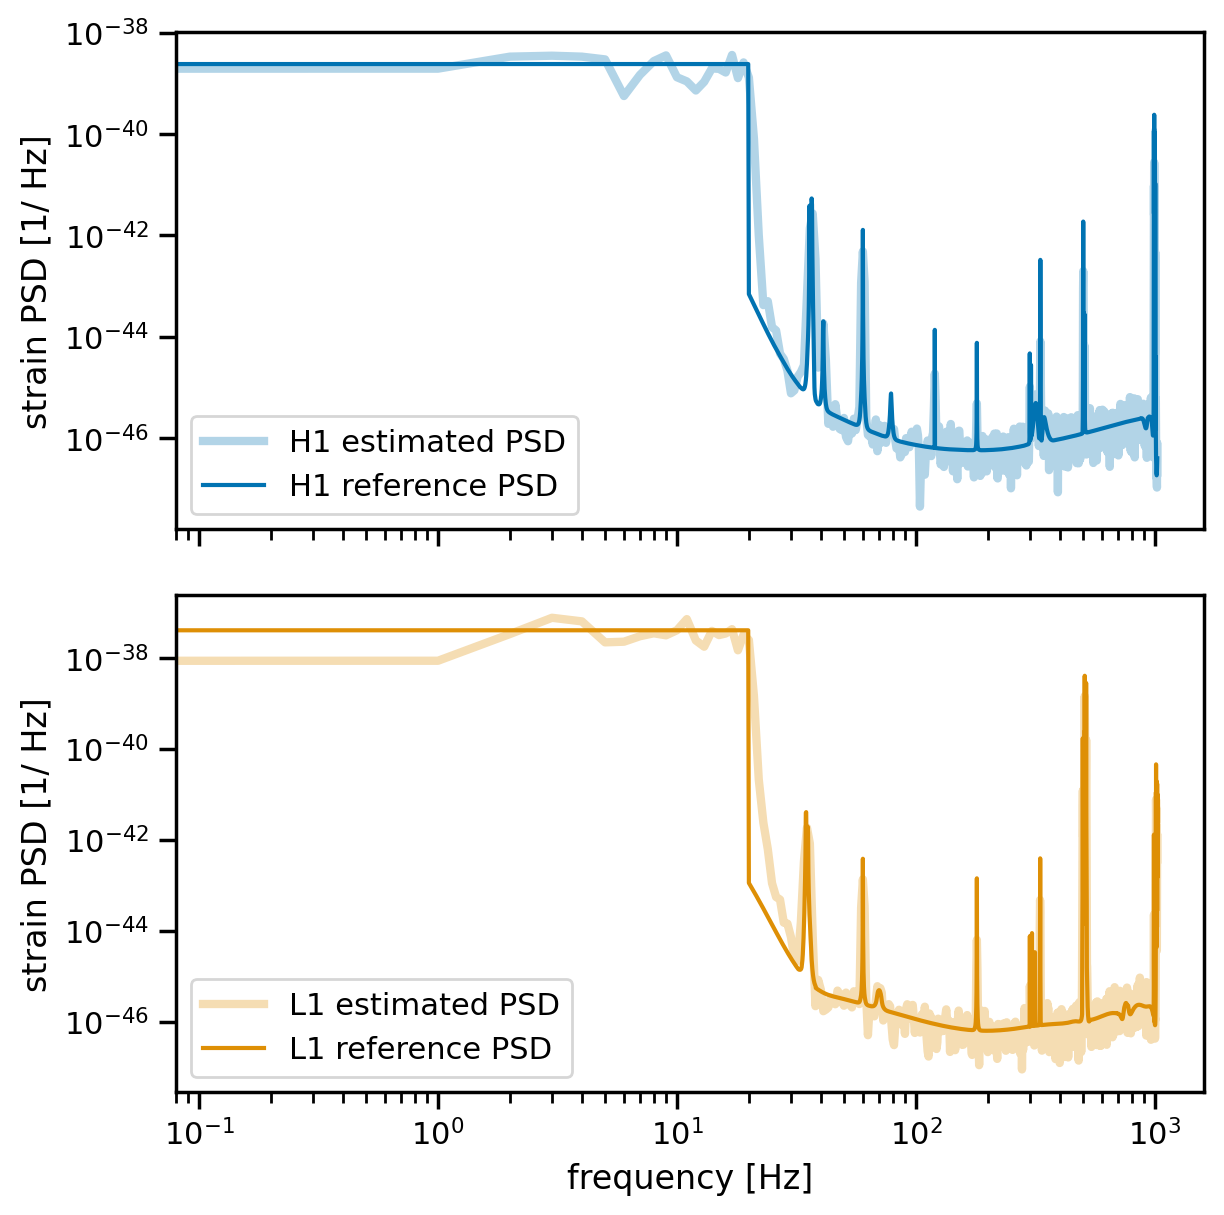

In [62]:
fig, axs = plt.subplots(len(fit.ifos), 1, figsize=(6, 6), sharex=True)
plt.tight_layout()
axs = np.atleast_1d(axs)
for i, (ifo, data) in enumerate(fit.data.items()):
    ax = axs[i]
    psd_estimate = data.get_psd()
    psd_ligo = psds_o1[ifo]
    ax.loglog(psd_estimate, label=f'{ifo} estimated PSD', lw=3, alpha=0.3, c=f'C{i}')
    ax.loglog(psd_ligo, label=f'{ifo} reference PSD', c=f'C{i}')
    ax.set_ylabel('strain PSD [1/ Hz]');
    ax.legend(loc='lower left')
axs[-1].set_xlabel('frequency [Hz]');


## Fake signal

Now that we have some fake data in our fit, we can inject a fake signal. We will use the `NRSur7dq4` model to simulate an inspiral-merger-ringdown (IMR) signal similar to GW150914 and project into onto the LIGO network.

To do this we will use `Fit.inject()`, which allows us to interact with LALSimulation in a straightforward way.

In [63]:
# tell LALSimulation where to find the NRSur7dq4 data file
os.environ["LAL_DATA_PATH"] = os.getcwd()

wf_kws = dict(
    model='NRSur7dq4',  # waveform approximant
    mtot = 72,  # total mass in solar masses
    q=1,  # mass ratio m2/m1 < 1 
    ra = 1.952318922,  # right ascension
    dec = -1.26967171703,  # declination
    psi = 0.824043851821,  # polarization
    inclination = np.pi,  # inclination
    dist = 440,  # luminosity distance in Mpc
    phi_ref = 2.41342424662,  # reference phase
    geocent_time = tgps_geo,  # peak time
    f_low = 15,  # initial frequency
)

fit.inject(manual_epoch=True, window=True, **wf_kws)

Simulated signals corresponding to these parameters have been added to each of the detectors for which we have data. We can access the templates by looking in `fit.injections`. Let's plot the signals we just simulated, and zoom around the merger.

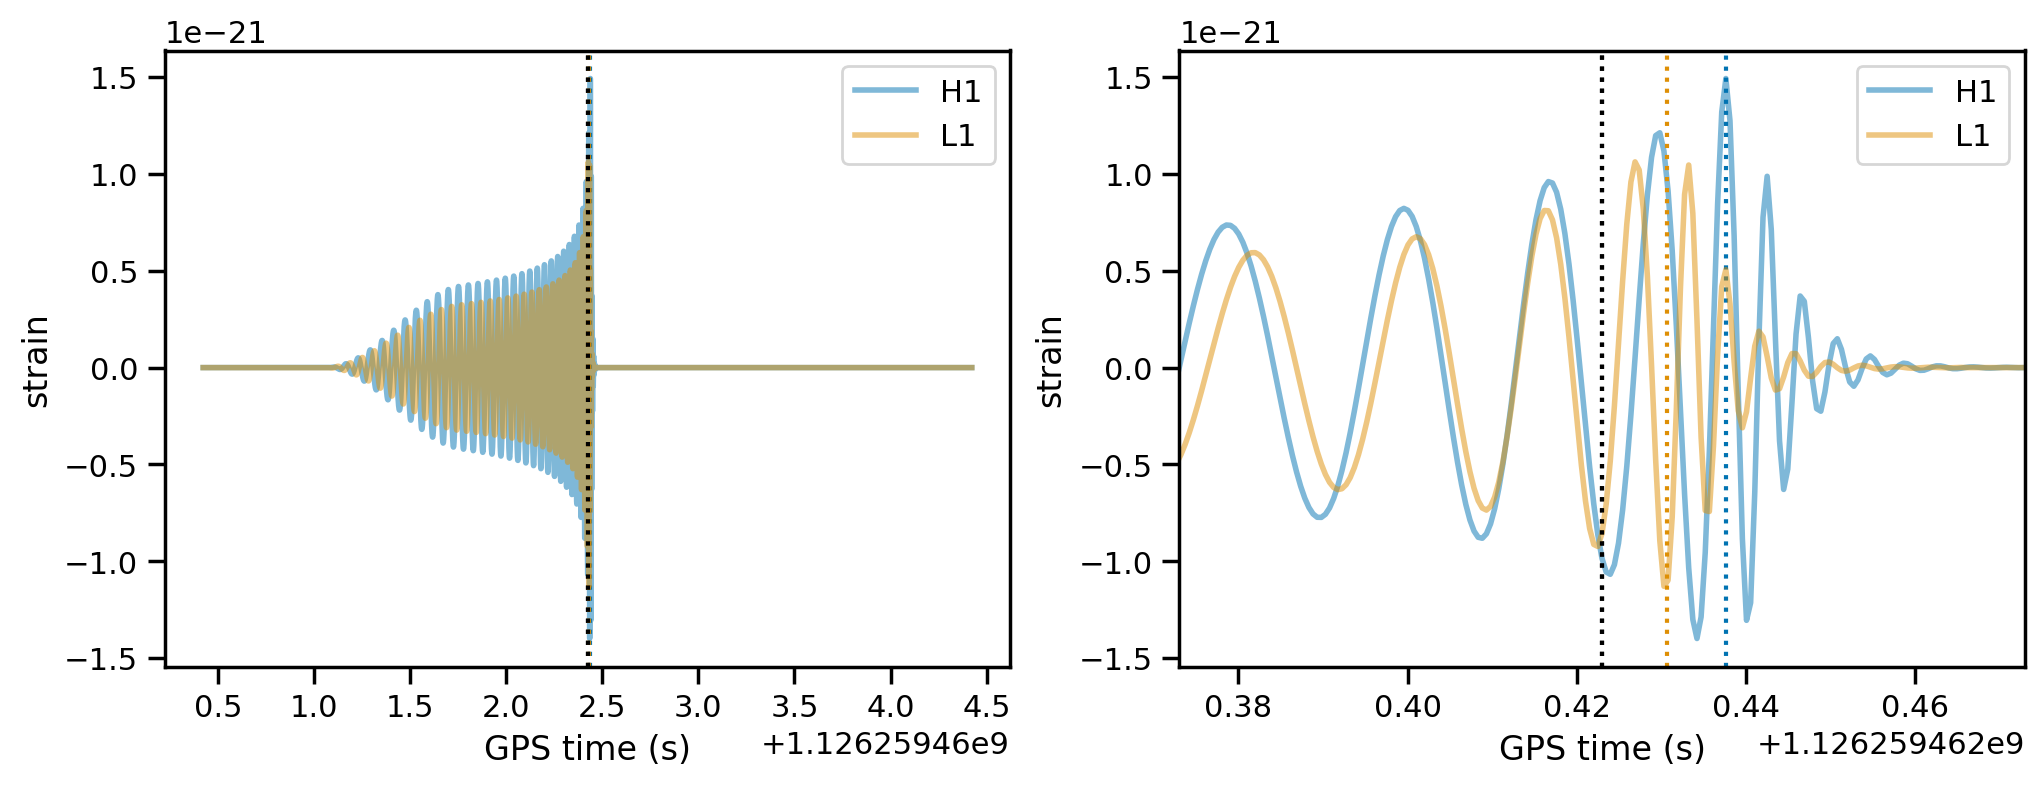

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
for ifo, h in fit.injections.items():
    for ax in axs:
        l, = ax.plot(h, alpha=0.5, lw=2, label=ifo)
        ax.axvline(h.attrs['t0']+h.attrs['delay'], ls=':', c=l.get_color())

        ax.axvline(tgps_geo, ls=':', c='k')

        ax.set_xlabel("GPS time (s)")
        ax.set_ylabel("strain")
        ax.legend();

# zoom in for secondary axes
axs[-1].set_xlim(tgps_geo - 0.05, tgps_geo + 0.05);

The vertical dotted lines show the arrival time of the peak of the strain envelope ($\sqrt{h_+^2 + h_\times^2}$) at geocenter (black) and each detector (color). By indicating `manual_epoch=True` we ensured the trigger time is interpreted as the time of this peak, so that the geocenter time is the same we had indicated above.

We can now compare this signal to the PSDs of our simulated data and compute and injected (optimal) SNR. We will plot the _characteristic strain_ as defined in [Moore et al (2015)](https://iopscience.iop.org/article/10.1088/0264-9381/32/1/015014).

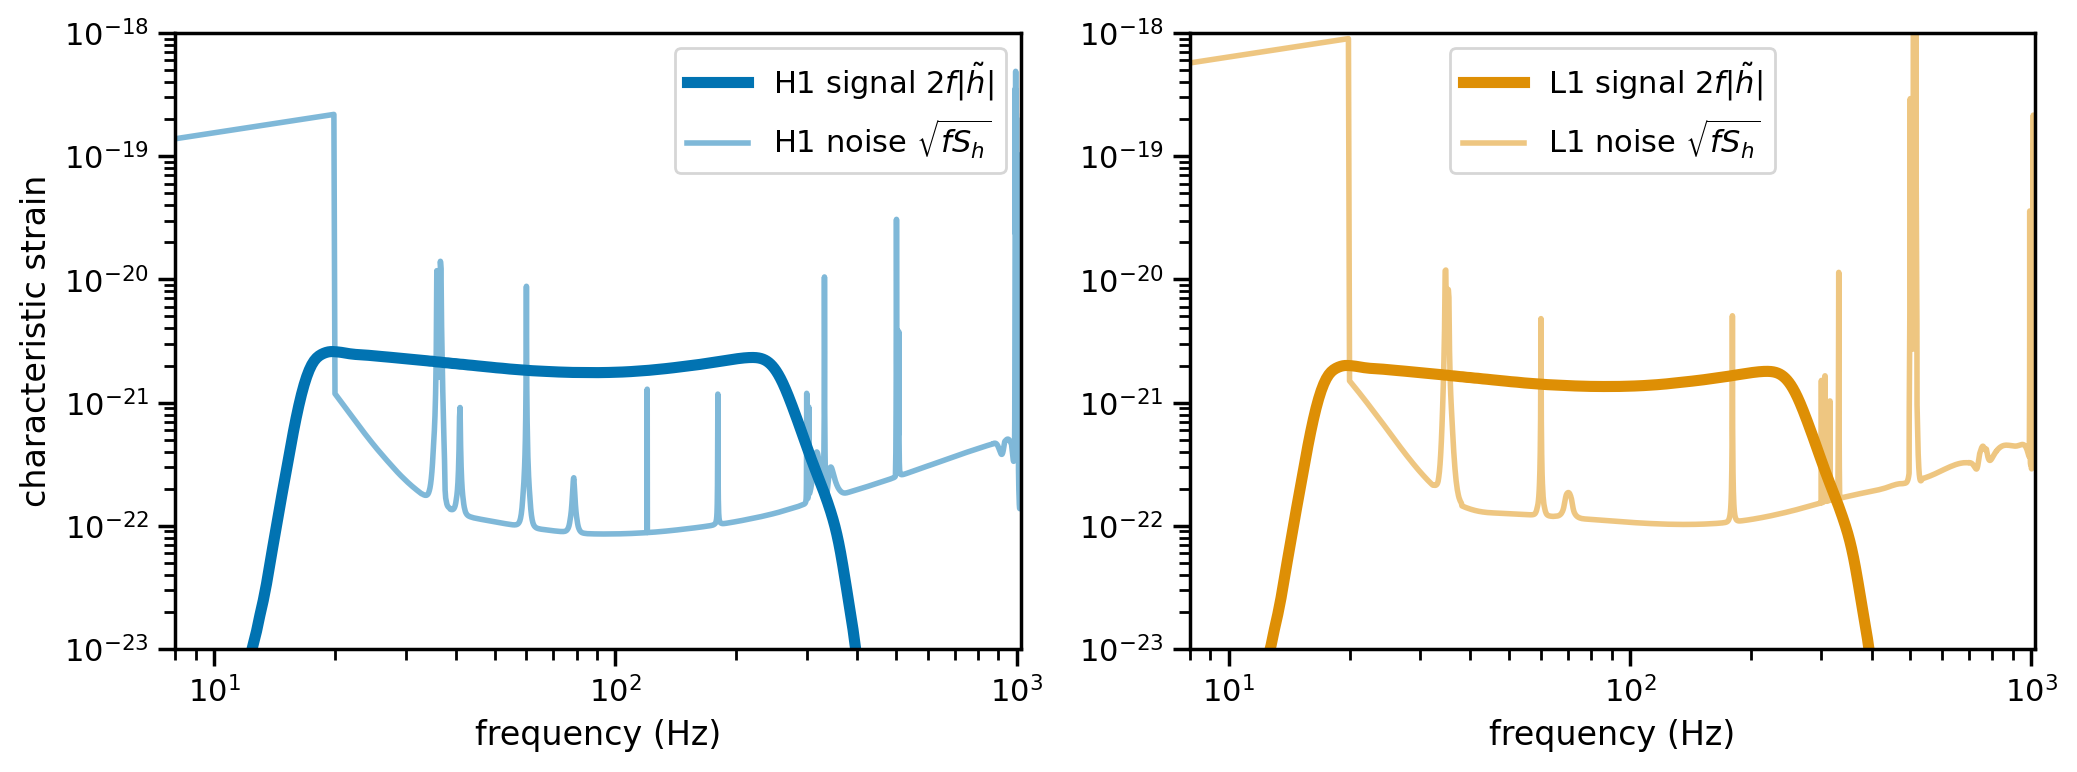

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = np.atleast_1d(axs)

snrs = {}
for i, (ifo, h) in enumerate(fit.injections.items()):
    ax = axs[i]
    
    # plot Fourier transform injected waveform
    h_fd = h.to_frequency_series()
    l, = ax.loglog(h_fd.freq, 2*abs(h_fd)*h_fd.freq, label=ifo+r' signal $2 f |\tilde{h}|$', lw=4, c=f'C{i}')

    # plot characteristic strain corresponding to PSD
    psd = psds_o1[ifo]    
    ax.loglog(psd.freq, np.sqrt(psd*psd.freq), c=f'C{i}', lw=2, alpha=0.5, label=ifo+r' noise $\sqrt{f S_h}$', )

    # compute optimal SNR at detector
    h_fd_flow20 = h_fd.loc[20:]
    psd_interp = psd.interpolate_to_index(h_fd_flow20.freq)
    snrs[ifo] = np.sqrt(4*np.sum(np.abs(h_fd_flow20)**2 * h_fd.delta_f/ psd_interp).real)

    ax.set_ylim(1E-23, 1E-18)
    ax.set_xlim(8, 1024)
    ax.legend()
    ax.set_xlabel("frequency (Hz)")
axs[0].set_ylabel(r"characteristic strain")

# compute network SNR
snrs['net'] = np.linalg.norm(list(snrs.values()))

In [66]:
snrs

{'H1': 26.921443088760647, 'L1': 18.325239358145776, 'net': 32.56652415463943}

<div class="alert alert-info">

Tip

The `Fit.inject()` method makes use of the _ringdown_ waveform interface, which can seamlessly handle IMR and damped-sinusoid injections. See the docs for `ringdown.Signal` to learn more.

</div>

## Fit

We are now finally ready to carry out a ringdown fit! We will set the modes for the fit and the target time (see other examples for discussion of these).

In [67]:
fit.set_modes([(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])

In [70]:
# get M in seconds (approximating remnant mass as 95% the total mass)
tM = 0.95*wf_kws['mtot']*rd.qnms.T_MSUN

# the start time for the ringdown model
t0 = tgps_geo + 0*tM

# collect sky location arguments
skyloc = {k: fit.injection_parameters[k] for k in ['ra', 'dec', 'psi']}

fit.set_target(t0, duration=0.05, **skyloc)

In [73]:
fit.target, fit.duration

(SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 423000097), ra=1.952318922, dec=-1.26967171703, psi=0.824043851821),
 0.05)

In [89]:
fit.update_model(a_scale_max=5e-21, m_min=35.0, m_max=140.0, cosi=-1)

In [90]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

`fit.result` contains an arviz object giving our results:

We can plot a trace, and see visually that the sampling seems OK:

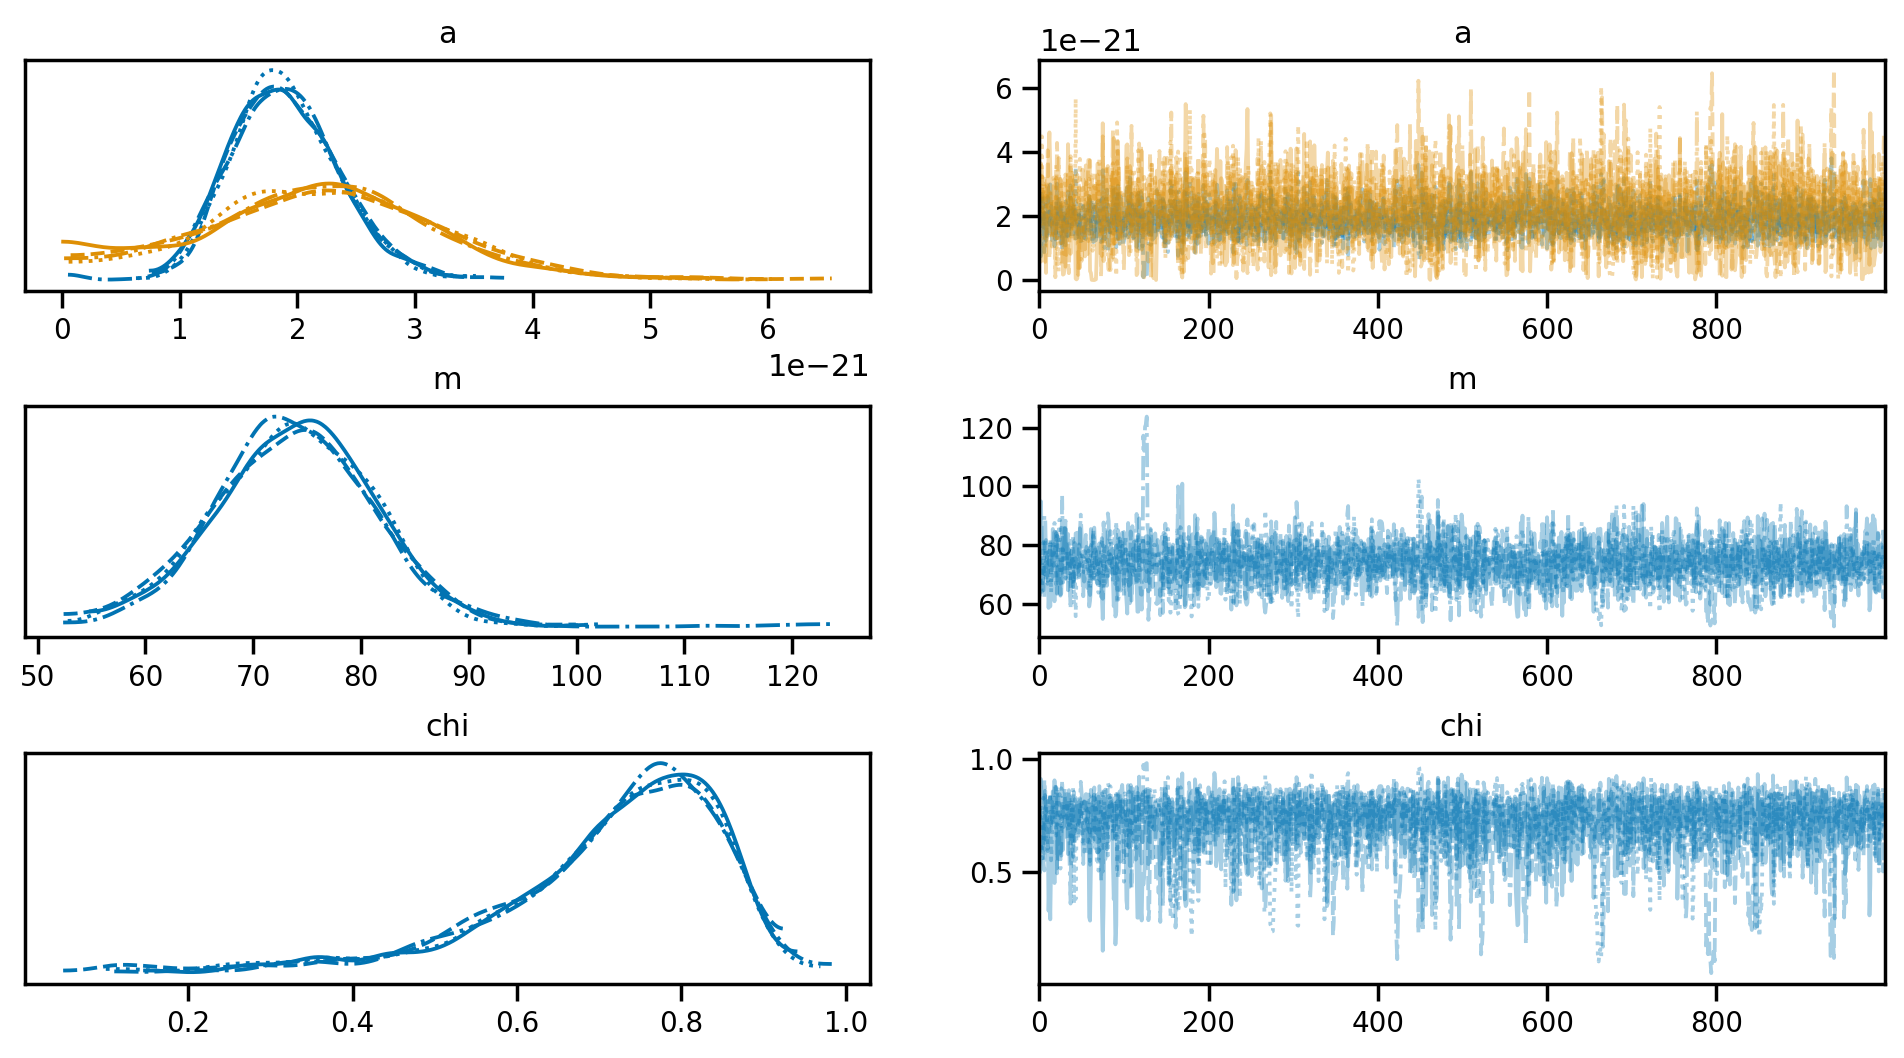

In [96]:
az.plot_trace(fit.result, var_names=['a', 'm', 'chi'], compact=True);
plt.subplots_adjust(hspace=0.5)

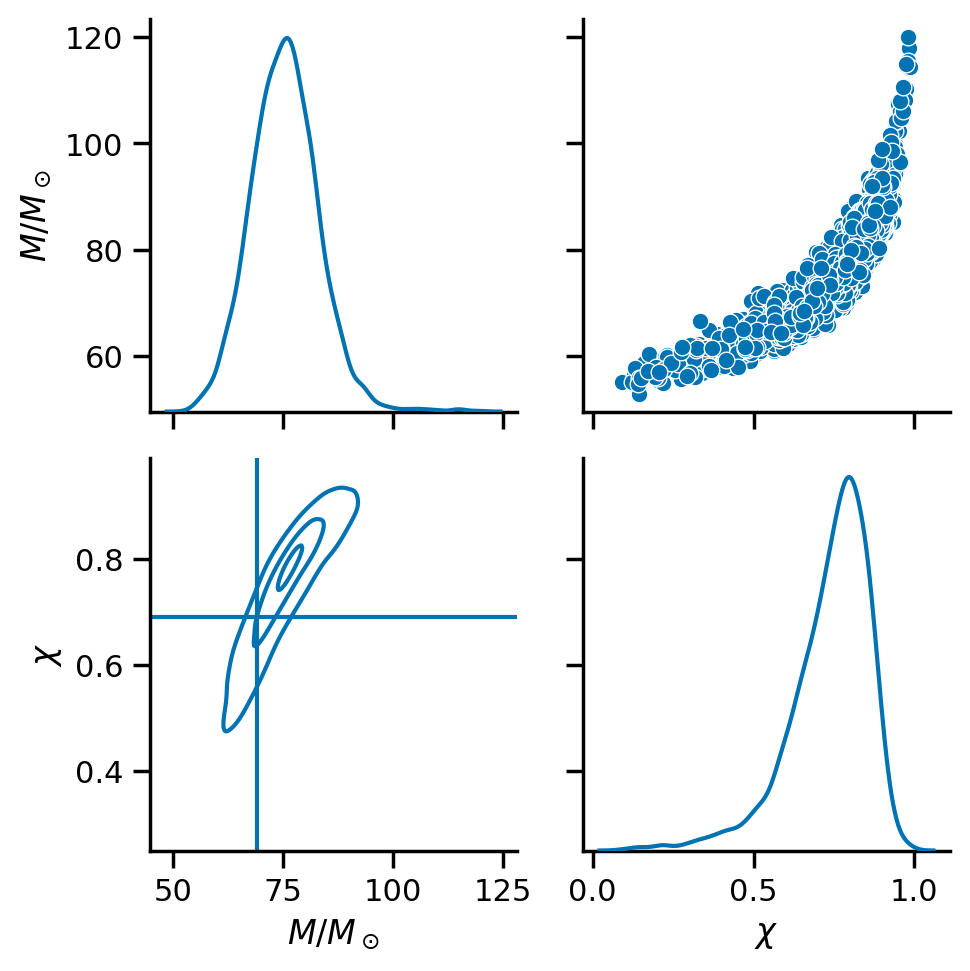

In [86]:
df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.m.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(rd.utils.kde_contour.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

# plot true values
pg.axes[1,0].axvline(69)
pg.axes[1,0].axhline(0.69)